# ExoWrap: First Atmosphere Simulation 🪐
Let's test our new Python wrapper for the ExoREM Fortran backend. We will define a hot Jupiter, run the radiative-convective equilibrium model, and plot the resulting Temperature-Pressure profile.

In [1]:
import exowrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(f"exowrap version: {exowrap.__version__}")

exowrap version: 0.1.0


## 1. Define Planet Parameters
We pass our physical parameters as a simple Python dictionary. `exowrap` will translate this into the complex Fortran namelist behind the scenes.

In [2]:
params = {
    "mass": 1.5,        # Planet mass in Jupiter masses
    "T_int": 400,       # Internal heat (K)
    "T_irr": 1200,      # Irradiation from the host star (K)
    "Met": 0.5,         # Metallicity [Fe/H] (log10 relative to solar)
    "f_sed": 2,         # Cloud sedimentation parameter
    "kzz": 8.0,         # Eddy diffusion coefficient (log10 cm^2/s)
    "g_1bar": 15.0      # Surface gravity at 1 bar (m/s^2)
}

## 2. Run the Simulation
This cell will create a temporary directory, build the `input.nml` file, execute the compiled Fortran `exorem.exe` binary, parse the resulting HDF5 file, and return a Pandas DataFrame.
*(Note: If the Fortran code crashes, change `keep_run_files=True` to inspect the raw output folder).*

In [3]:
# Initialize the model
# Save it to a dedicated tests folder
model = exowrap.Simulation(
    params=params, 
    output_dir="../tests/hot_jupiters/"
)

try:
    # Run the Fortran backend
    results_df = model.run()
    print("Simulation successful! Available data keys:")
    print(results_df.columns.tolist()[:15])

except RuntimeError as e:
    # If Fortran crashes, Jupyter will cleanly print the Fortran terminal output here!
    print(e)
    
    # You can also access the raw strings anytime via the model object:
    # print(model.last_stderr)

INFO: Starting ExoREM Simulation...
INFO: Generated namelist at /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpfnhyooku/input.nml
INFO: Running Fortran backend from /Users/cwilkinson/.exowrap/exorem_source/dist/dist/exorem/bin...
INFO: Parsing results from /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpfnhyooku/outputs/exowrap_run.h5...
INFO: 💾 Permanently saved HDF5 to: ../tests/hot_jupiters/exorem_Tint400_g15.0.h5
INFO: Simulation complete.


Simulation successful! Available data keys:
['/model_parameters/atmosphere/eddy_mode', '/model_parameters/clouds/fraction', '/model_parameters/clouds/mode', '/model_parameters/clouds/particle_density/H2O', '/model_parameters/clouds/particle_density/KCl', '/model_parameters/clouds/particle_radius/H2O', '/model_parameters/clouds/particle_radius/KCl', '/model_parameters/clouds/reference_wavenumber/H2O', '/model_parameters/clouds/reference_wavenumber/KCl', '/model_parameters/clouds/sedimentation_parameter/H2O', '/model_parameters/clouds/sedimentation_parameter/KCl', '/model_parameters/light_source/effective_temperature', '/model_parameters/light_source/radius', '/model_parameters/light_source/range', '/model_parameters/light_source/spectral_irradiance']


In [4]:
actual_T_int = results_df['/outputs/run_quality/actual_internal_temperature'].iloc[0]
print(f"Targeted T_int: {params['T_int']} K")
print(f"Actual achieved T_int: {actual_T_int:.2f} K")

chi_squared = results_df['/outputs/run_quality/chi2_retrieval'].iloc[0]
print(f"Final Convergence Chi^2: {chi_squared}")

Targeted T_int: 400 K
Actual achieved T_int: 400.19 K
Final Convergence Chi^2: 18164.83556446347


## 3. Plot the Temperature-Pressure Profile and spectrum
The `results_df` contains our atmosphere profiles stored as arrays within a single row. Let's extract the pressure and temperature layers and plot them. In atmospheric science, we always plot Pressure on the Y-axis, inverted (high pressure at the bottom), on a log scale.

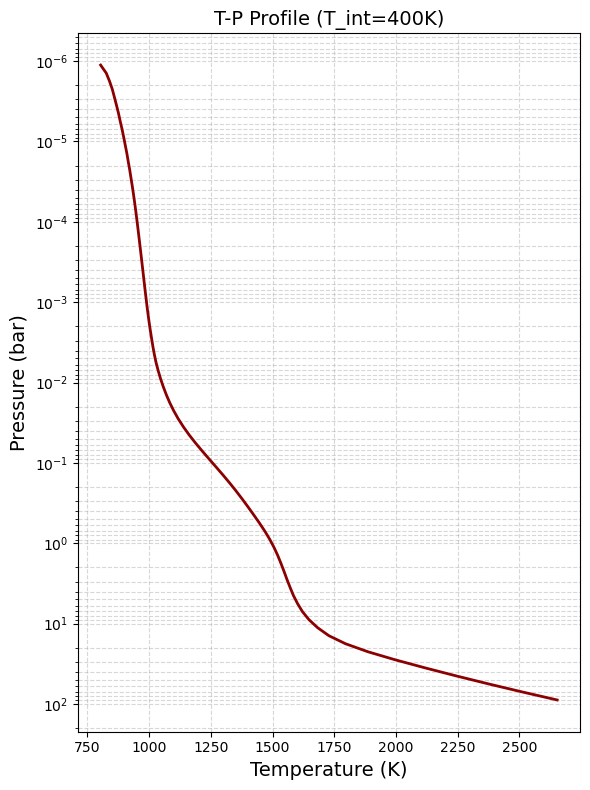

In [5]:
ax1 = exowrap.plot_tp_profile(results_df, title=f"T-P Profile (T_int={params['T_int']}K)")
plt.show()

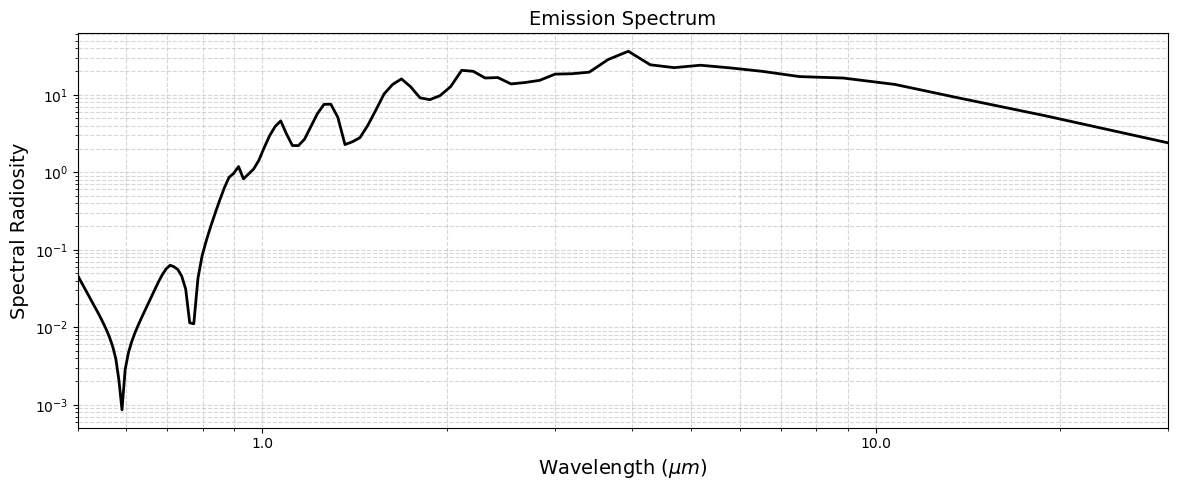

In [6]:
# And plotting the spectrum!
ax2 = exowrap.plot_emission_spectrum(results_df)

# Because our function returns the matplotlib axis, you can easily customize it afterward!
ax2.set_xlim(0.5, 30) # Zoom in on the 0.5 to 30 micron range
plt.show()

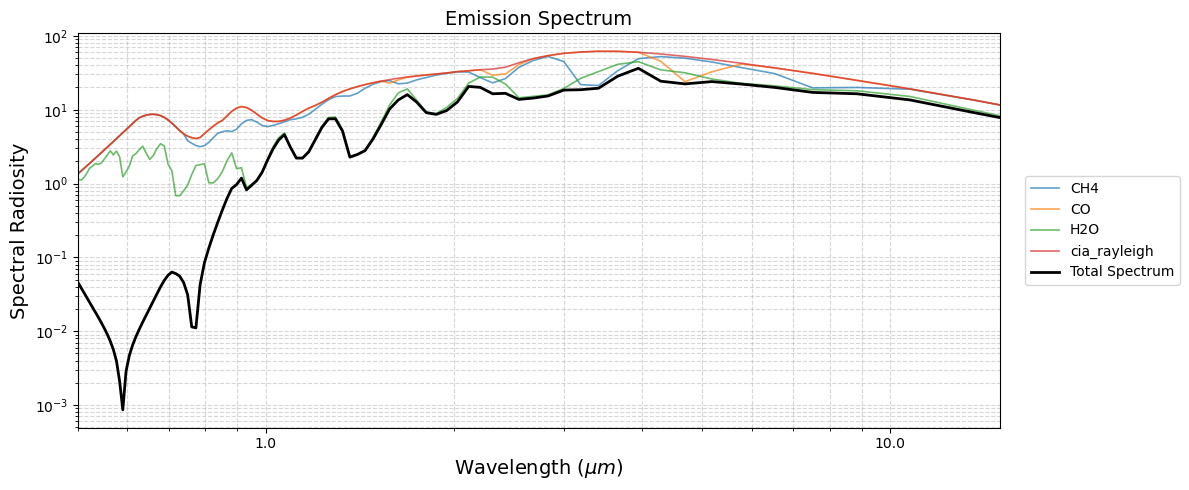

In [7]:
# Let's plot the baseline continuum (cia_rayleigh), plus water and methane, 
# and the total spectrum will be drawn on top!
mols_to_plot = ['cia_rayleigh', 'H2O', 'CH4', 'CO']

ax = exowrap.plot_emission_spectrum(results_df, contributions=mols_to_plot)

# Zoom in on the JWST range
if ax:
    ax.set_xlim(0.5, 15)
    plt.show()

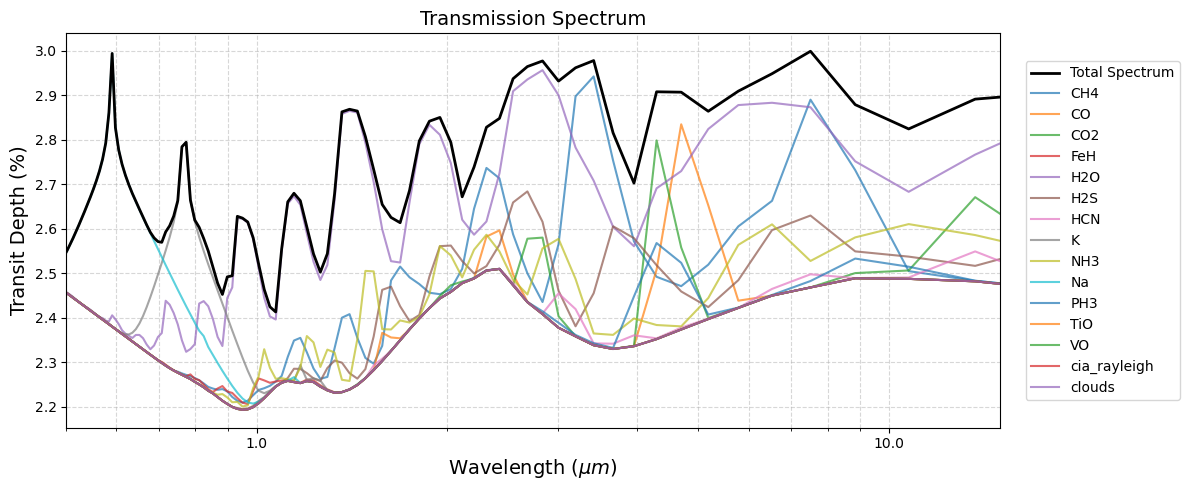

In [8]:
# Plot total spectrum and EVERY contribution available in the HDF5 file
ax = exowrap.plot_transmission_spectrum(results_df, contributions=True)
ax.set_xlim(0.5, 15)
plt.show()

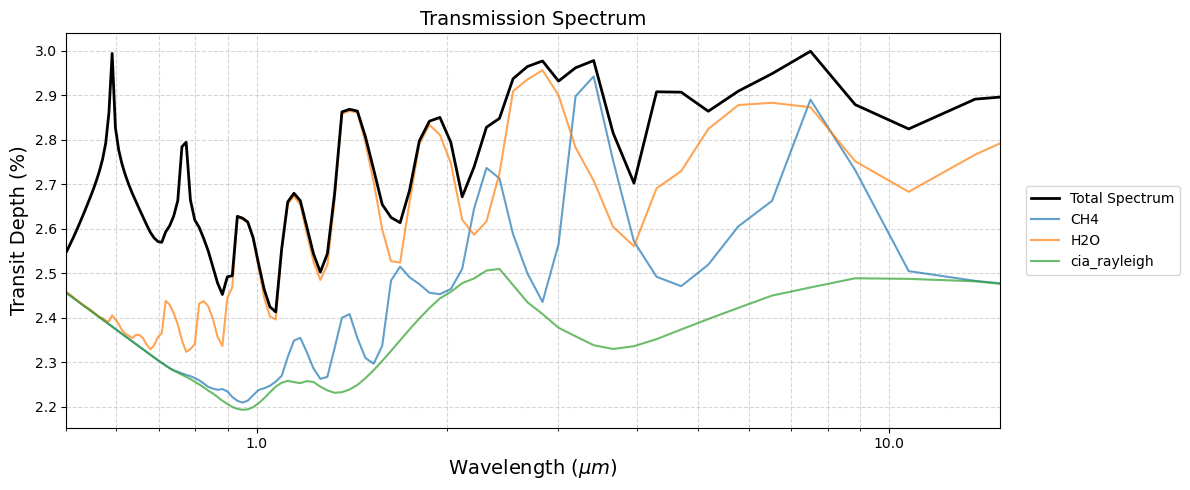

In [9]:
# Plot total spectrum alongside just Water, Methane, and the base CIA/Rayleigh scattering
mols_to_plot = ['H2O', 'CH4', 'cia_rayleigh']

ax = exowrap.plot_transmission_spectrum(results_df, contributions=mols_to_plot)
ax.set_xlim(0.5, 15)
plt.show()

<Axes: title={'center': 'Chemical Abundances (VMR)'}, xlabel='Volume Mixing Ratio (VMR)', ylabel='Pressure (bar)'>

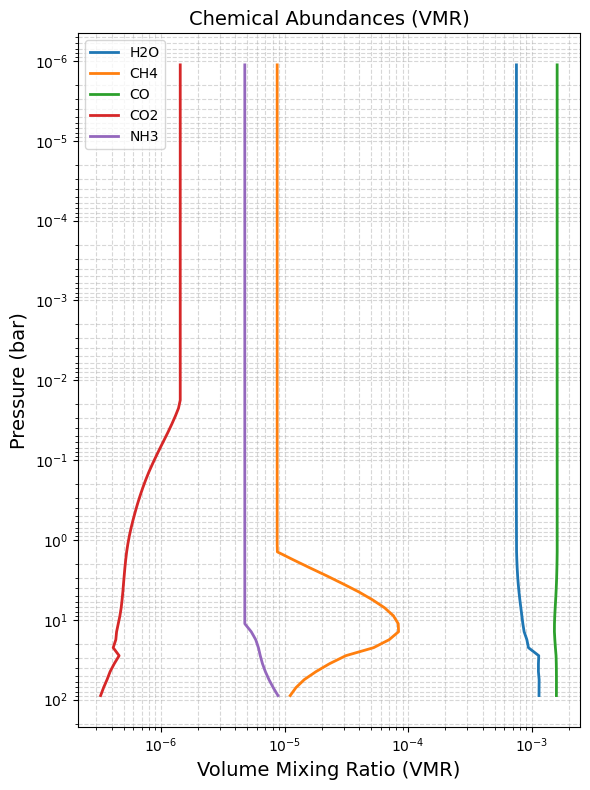

In [10]:
exowrap.plot_vmr_profile(results_df, molecules=['H2O', 'CH4', 'CO', 'CO2', 'NH3'])

# Higher resolution models

In [2]:
params = {
    "mass": 1.5,        # Planet mass in Jupiter masses
    "T_int": 400,       # Internal heat (K)
    "T_irr": 1200,      # Irradiation from the host star (K)
    "Met": 0.5,         # Metallicity [Fe/H] (log10 relative to solar)
    "f_sed": 2,         # Cloud sedimentation parameter
    "kzz": 8.0,         # Eddy diffusion coefficient (log10 cm^2/s)
    "g_1bar": 15.0      # Surface gravity at 1 bar (m/s^2)
}

In [3]:
model_r50 = exowrap.Simulation(
    params=params, 
    resolution=50, 
    output_dir="../tests/hot_jupiters/"
)

# Run the Fortran backend
results_r50 = model_r50.run()

print("✅ Low-resolution simulation complete!")

INFO: Starting ExoREM Simulation...
INFO: Generated namelist at /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpx1gdt5fx/input.nml
INFO: Running Fortran backend from /Users/cwilkinson/.exowrap/exorem_source/dist/dist/exorem/bin...
INFO: Parsing results from /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpx1gdt5fx/outputs/exowrap_run.h5...
INFO: 💾 Permanently saved HDF5 to: ../tests/hot_jupiters/exorem_Tint400_g15.0.h5
INFO: Simulation complete.


✅ Low-resolution simulation complete!


In [4]:
# Using the same parameters you set up earlier
model_r500 = exowrap.Simulation(
    params=params, 
    resolution=500, 
    output_dir="../tests/hot_jupiters/"
)

# Run it! (This might take slightly longer to converge than R50)
results_r500 = model_r500.run()

print("✅ High-resolution simulation complete!")

INFO: Starting ExoREM Simulation...
INFO: Generated namelist at /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpvw4_1wvv/input.nml
INFO: Running Fortran backend from /Users/cwilkinson/.exowrap/exorem_source/dist/dist/exorem/bin...
INFO: Parsing results from /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpvw4_1wvv/outputs/exowrap_run.h5...
INFO: 💾 Permanently saved HDF5 to: ../tests/hot_jupiters/exorem_Tint400_g15.0.h5
INFO: Simulation complete.


✅ High-resolution simulation complete!


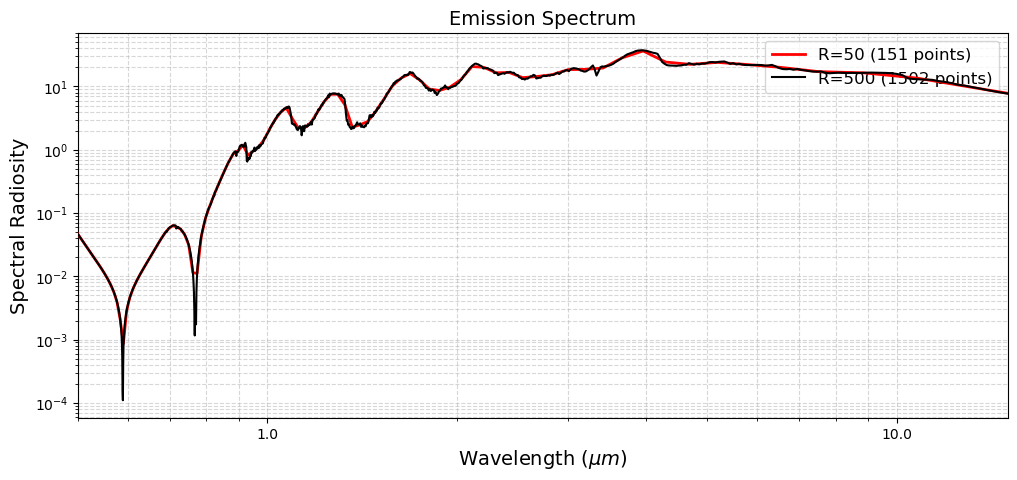

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Dynamically calculate the number of valid spectral points
wavenumber_r50 = results_r50['/outputs/spectra/wavenumber'].iloc[0]
n_pts_r50 = np.sum(wavenumber_r50 > 0)

wavenumber_r500 = results_r500['/outputs/spectra/wavenumber'].iloc[0]
n_pts_r500 = np.sum(wavenumber_r500 > 0)

# 2. Create a single, shared canvas
fig, shared_ax = plt.subplots(figsize=(12, 5))

# 3. Plot the R=50 model first
exowrap.plot_emission_spectrum(
    results_r50, 
    ax=shared_ax, 
    color='red', 
    lw=2,
    title="High-Res vs Low-Res Emission Spectrum"
)

# 4. Plot the R=500 model on top
exowrap.plot_emission_spectrum(
    results_r500, 
    ax=shared_ax, 
    color='black', 
    lw=1.5
)

# 5. Zoom in
shared_ax.set_xlim(0.5, 15)

# 6. Apply our dynamic legend!
label_r50 = f"R=50 ({n_pts_r50} points)"
label_r500 = f"R=500 ({n_pts_r500} points)"
shared_ax.legend([label_r50, label_r500], loc='upper right', fontsize=12)

plt.show()